In [1]:
import csv
import os
from collections import defaultdict
from datetime import datetime
from datetime import timedelta

import matplotlib
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
total_colums = [
    # Ejemplar
    'TITULO', 'AUTOR', 'EDITORIAL', 'SUCURSAL', 'DESC_SUCURSAL', 'COD_BARRAS_LIBRO', 'NUM_TITULO', 'SIG_TOPOGRAFICA',
    'DEWEY', 'II_SUMARIO', 'I_SUMARIO', 'EDICION', 'LOCALIZACION_EJEMPLAR', 'DESC_LOCALIZACION_EJEMPLAR', 'POLITICA',
    'DESC_POLITICA_EJEMPLAR', 'ISBN', 'FECHA_REGISTRO_EJEMPLAR', 'FECHA_ADICION_EJEMPLAR', 'FECHA_PUB',
    'ESTADO_EJEMPLAR', 'PAIS_EJEMPLAR',
    # Usuario (I)
    'OCUPACION', 'NIVEL_EDUCACION', 'AREA_ESTUDIO',
    # Prestamo (I)
    'SUCURSAL_PRESTAMO', 'SUCURSAL_DEVOLUCION',
    # Usuario (II)
    'SUCURSAL_DEL_LECTOR', 'COD_BARRAS_LECTOR', 'CATEGORÍA',
    # Prestamo (II)
    'FECHA_PRESTAMO', 'FECHA_REAL_DEVOLUCION',
]

In [3]:
used_colums = [
    # Ejemplar
    'TITULO', 'AUTOR', 'SUCURSAL', 'COD_BARRAS_LIBRO', 'DEWEY', 'DESC_LOCALIZACION_EJEMPLAR',
    'FECHA_PUB','PAIS_EJEMPLAR',
    # Usuario (I)
    'OCUPACION','NIVEL_EDUCACION','AREA_ESTUDIO',
    # Prestamo (I)
    'SUCURSAL_PRESTAMO','SUCURSAL_DEVOLUCION',
    # Usuario (II)
    'SUCURSAL_DEL_LECTOR', 'COD_BARRAS_LECTOR', 'CATEGORÍA',
    # Prestamo (II)
    'FECHA_PRESTAMO','FECHA_REAL_DEVOLUCION'
]

# Datos limpios

In [4]:
%%time

dtypes = {
    'TITULO': str,
    'AUTOR': str,
    'SUCURSAL': str,
    'COD_BARRAS_LIBRO': str,
    'DEWEY': str,
    'DESC_LOCALIZACION_EJEMPLAR': str,
    'FECHA_PUB': str,
    'PAIS_EJEMPLAR': str,
    'OCUPACION': str,
    'NIVEL_EDUCACION': str,
    'AREA_ESTUDIO': str,
    'SUCURSAL_PRESTAMO': str,
    'SUCURSAL_DEVOLUCION': str,
    'SUCURSAL_DEL_LECTOR': str,
    'COD_BARRAS_LECTOR': str,
    'CATEGORÍA': str,
    'FECHA_PRESTAMO': str,
    'FECHA_REAL_DEVOLUCION': str,
    'DATE_PRESTAMO': pd.tslib.Timestamp,
    'DATE_DEVOLUCION': pd.tslib.Timestamp,
}

prestamos_df = pd.read_csv('prestamos_totales.csv', header=0, dtype=dtypes, parse_dates=['DATE_PRESTAMO', 'DATE_DEVOLUCION'])
prestamos_df = prestamos_df.fillna('')

CPU times: user 19 s, sys: 1.06 s, total: 20.1 s
Wall time: 21.6 s


In [5]:
prestamos_df.shape

(3054360, 20)

In [6]:
prestamos_df.head()

,TITULO,AUTOR,SUCURSAL,COD_BARRAS_LIBRO,DEWEY,DESC_LOCALIZACION_EJEMPLAR,FECHA_PUB,PAIS_EJEMPLAR,OCUPACION,NIVEL_EDUCACION,AREA_ESTUDIO,SUCURSAL_PRESTAMO,SUCURSAL_DEVOLUCION,SUCURSAL_DEL_LECTOR,COD_BARRAS_LECTOR,CATEGORÍA,FECHA_PRESTAMO,FECHA_REAL_DEVOLUCION,DATE_PRESTAMO,DATE_DEVOLUCION
0,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429527,CTA,22/01/2015,04/02/2015,2015-01-22,2015-02-04
1,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88416381,CTA,31/03/2015,07/04/2015,2015-03-31,2015-04-07
2,Quisiera tener ...,"Zoboli, Giovanna.",ARM,2284458,853,Infantil,2010,mx,,,,ARM,ARM,ARM,88381353,CTA,07/11/2015,17/11/2015,2015-11-07,2015-11-17
3,Johannes Gutenberg,"Borràs Perelló, Lluís.",ARM,2288922,925,Infantil,2010,sp,Empleado,Técnico,Adm. de empresas,ARM,ARM,ARM,88007424,CEM,16/01/2015,16/01/2015,2015-01-16,2015-01-16
4,La fantástica leyenda de: la princesa y el dragón,"Alins, Sonia.",ARM,2288896,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429529,CTA,21/01/2015,28/01/2015,2015-01-21,2015-01-28


# Libros viajeros

In [17]:
sucursales = {
    'ARM': {'name': 'Armenia', 'latitude': 4.53, 'longitude': -75.68},
    'BAR': {'name': 'Barranquilla', 'latitude': 10.963889, 'longitude': -74.796389},
    'BLAA': {'name': 'Luis Angel Arango', 'latitude': 4.59677, 'longitude': -74.072848},
    'BUC': {'name': 'Bucaramanga', 'latitude': 7.133333, 'longitude': -73},
    'BUE': {'name': 'Buenaventura', 'latitude': 3.877222, 'longitude': -77.026667},
    'CAL': {'name': 'Cali', 'latitude': 3.420556, 'longitude': -76.522222},
    'CAR': {'name': 'Cartagena', 'latitude': 10.4, 'longitude': -75.5},
    'CASAGO': {'name': 'Casa Gómez Campuzano', 'latitude': 4.6628468, 'longitude': -74.0512116},
    'CATMAN': {'name': 'Catalogación y Mantenimiento de Colecciones', 'latitude': 4.5769749, 'longitude': -74.0880581},
    'CUC': {'name': 'Cúcuta', 'latitude': 7.894167, 'longitude': -72.503889},
    'ESPE': {'name': 'Espinal', 'latitude': 4.152778, 'longitude': -74.888611}, # provisional
    'FLO': {'name': 'Florencia', 'latitude': 1.614167, 'longitude': -75.611667},
    'GIR': {'name': 'Girardot', 'latitude': 4.305, 'longitude': -74.801667},
    'HON': {'name': 'Honda', 'latitude': 5.204167, 'longitude': -74.741667},
    'IBA': {'name': 'Ibagué', 'latitude': 4.433333, 'longitude': -75.233333},
    'IEC': {'name': 'Investigaciones Económicas', 'latitude': 4.5769749, 'longitude': -74.06}, # geo?
    'IPI': {'name': 'Ipiales', 'latitude': 0.830278, 'longitude': -77.644444},
    'LET': {'name': 'Leticia', 'latitude': -4.205278, 'longitude': -69.932778},
    'MAN': {'name': 'Manizales', 'latitude': 5.1, 'longitude': -75.55},
    'MED': {'name': 'Medellín', 'latitude': 6.230833, 'longitude': -75.590556},
    'MON': {'name': 'Montería', 'latitude': 8.75, 'longitude': -75.883333},
    'NEI': {'name': 'Neiva', 'latitude': 2.998611, 'longitude': -75.304444},
    'PAS': {'name': 'Pasto', 'latitude': 1.207778, 'longitude': -77.277222},
    'PER': {'name': 'Pereira', 'latitude': 4.814278, 'longitude': -75.694558},
    'POP': {'name': 'Popayán', 'latitude': 2.454167, 'longitude': -76.609167},
    'QUI': {'name': 'Quibdó', 'latitude': 5.692222, 'longitude': -76.658056},
    'RIO': {'name': 'Riohacha', 'latitude': 11.544167, 'longitude': -72.906944},
    'SAN': {'name': 'San Andrés', 'latitude': 12.583333, 'longitude': -81.7},
    'SIN': {'name': 'Sincelejo', 'latitude': 9.295, 'longitude': -75.396111},
    'STM': {'name': 'Santa Marta', 'latitude': 11.241944, 'longitude': -74.205278},
    'TUN': {'name': 'Tunja', 'latitude': 5.533333, 'longitude': -73.366667},
    'VAL': {'name': 'Valledupar', 'latitude': 10.483333, 'longitude': -73.25},
    'VIL': {'name': 'Villavicencio', 'latitude': 4.15, 'longitude': -73.633333},
}

## Grafo de préstamos, devoluciones y préstamos interbibliotecarios

In [19]:
%%time

graph = nx.MultiDiGraph()

for p in prestamos_df.iterrows():
    s_libro = p[1]['SUCURSAL']
    s_prest = p[1]['SUCURSAL_PRESTAMO']
    s_devol = p[1]['SUCURSAL_DEVOLUCION']
    
    if not graph.has_node(s_libro):
        graph.add_node(
            s_libro,
            apariciones=0,
            nombre=sucursales[s_libro]['name'],
            latitude=sucursales[s_libro]['orig_lat'],
            longitude=sucursales[s_libro]['orig_long']
        )
    graph.node[s_libro]['apariciones'] += 1
    if not graph.has_node(s_prest):
        graph.add_node(
            s_prest,
            apariciones=0,
            nombre=sucursales[s_prest]['name'],
            latitude=sucursales[s_prest]['orig_lat'],
            longitude=sucursales[s_prest]['orig_long']
        )
    graph.node[s_prest]['apariciones'] += 1
    if not graph.has_node(s_devol):
        graph.add_node(
            s_devol,
            apariciones=0,
            nombre=sucursales[s_devol]['name'],
            latitude=sucursales[s_devol]['orig_lat'],
            longitude=sucursales[s_devol]['orig_long']
        )
    graph.node[s_devol]['apariciones'] += 1
    
    if s_libro != s_prest:
        key = s_libro + '_' + s_prest + '_solicitud'
        if not graph.has_edge(s_libro, s_prest, key):
            graph.add_edge(s_libro, s_prest, key=key, label='solicitud', weight=0)
        graph[s_libro][s_prest][key]['weight'] += 1
    if s_prest != s_devol:
        key = s_prest + '_' + s_devol + '_viaje'
        if not graph.has_edge(s_prest, s_devol, key):
            graph.add_edge(s_prest, s_devol, key=key, label='viaje', weight=0)
        graph[s_prest][s_devol][key]['weight'] += 1
    if s_devol != s_libro:
        key = s_devol + '_' + s_libro + '_retorno'
        if not graph.has_edge(s_devol, s_libro, key):
            graph.add_edge(s_devol, s_libro, key=key, label='retorno', weight=0)
        graph[s_devol][s_libro][key]['weight'] += 1

CPU times: user 7min 42s, sys: 1.76 s, total: 7min 44s
Wall time: 7min 44s


In [20]:
len(graph)

33

In [21]:
graph.number_of_nodes()

33

In [22]:
graph.number_of_edges()

2195

In [74]:
for n in graph.nodes(data=True):
    n[1]['longitude'] = n[1]['orig_long']
    n[1]['latitude'] = n[1]['orig_lat']
    n[1]['lng'] = n[1]['orig_long']
    n[1]['lat'] = n[1]['orig_lat']


In [75]:
for n in graph.nodes(data=True):
    print(n)
    break

('ESPE', {'longitude': -74.888611, 'lng': -74.888611, 'apariciones': 54406, 'orig_long': -74.888611, 'orig_lat': 4.152778, 'latitude': 4.152778, 'nombre': 'Espinal', 'lat': 4.152778})


In [76]:
%%time

nx.write_gexf(graph, 'viajes.gexf')

CPU times: user 143 ms, sys: 3.96 ms, total: 147 ms
Wall time: 146 ms


In [95]:
%%time

graph = nx.MultiDiGraph()

for p in prestamos_df.iterrows():
    s_libro = p[1]['SUCURSAL']
    s_prest = p[1]['SUCURSAL_PRESTAMO']
    s_devol = p[1]['SUCURSAL_DEVOLUCION']
    
    if not graph.has_node(s_libro):
        graph.add_node(s_libro, nombre=sucursales.get(s_libro, 'DESCONOCIDO'), apariciones=0)
    graph.node[s_libro]['apariciones'] += 1
    if not graph.has_node(s_prest):
        graph.add_node(s_prest, nombre=sucursales.get(s_prest, 'DESCONOCIDO'), apariciones=0)
    graph.node[s_prest]['apariciones'] += 1
    if not graph.has_node(s_devol):
        graph.add_node(s_devol, nombre=sucursales.get(s_devol, 'DESCONOCIDO'), apariciones=0)
    graph.node[s_devol]['apariciones'] += 1
    
    if s_libro != s_prest:
        graph.add_edge(s_libro, s_prest, label='solicitud')
    if s_prest != s_devol:
        graph.add_edge(s_prest, s_devol, label='viaje')
    if s_devol != s_libro:
        graph.add_edge(s_devol, s_libro, label='retorno')

CPU times: user 8min 54s, sys: 1.96 s, total: 8min 56s
Wall time: 8min 56s


In [106]:
%%time

scaled_graph = nx.MultiDiGraph()

combinaciones_sucursales = {}
for s1 in sucursales:
    combinaciones_sucursales[s1] = {}
    for s2 in sucursales:
        if s2 != s1:
            combinaciones_sucursales[s1][s2] = {
                'solicitudes': 0,
                'viajes': 0,
                'retornos': 0,
            }

for p in prestamos_df.iterrows():
    s_libro = p[1]['SUCURSAL']
    s_prest = p[1]['SUCURSAL_PRESTAMO']
    s_devol = p[1]['SUCURSAL_DEVOLUCION']
    
    if not scaled_graph.has_node(s_libro):
        scaled_graph.add_node(s_libro, nombre=sucursales.get(s_libro, 'DESCONOCIDO'), apariciones=0)
    scaled_graph.node[s_libro]['apariciones'] += 1
    if not scaled_graph.has_node(s_prest):
        scaled_graph.add_node(s_prest, nombre=sucursales.get(s_prest, 'DESCONOCIDO'), apariciones=0)
    scaled_graph.node[s_prest]['apariciones'] += 1
    if not scaled_graph.has_node(s_devol):
        scaled_graph.add_node(s_devol, nombre=sucursales.get(s_devol, 'DESCONOCIDO'), apariciones=0)
    scaled_graph.node[s_devol]['apariciones'] += 1
    
    if s_libro != s_prest:
        combinaciones_sucursales[s_libro][s_prest]['solicitudes'] += 1
    if s_prest != s_devol:
        combinaciones_sucursales[s_prest][s_devol]['viajes'] += 1
    if s_devol != s_libro:
        combinaciones_sucursales[s_devol][s_libro]['retornos'] += 1

CPU times: user 8min 8s, sys: 1.11 s, total: 8min 9s
Wall time: 8min 14s


In [107]:
N = 10

In [110]:
for s1 in combinaciones_sucursales:
    for s2 in combinaciones_sucursales[s1]:
        n = combinaciones_sucursales[s1][s2]['solicitudes']
        n = N if 1 <= n <= N else n
        for _ in range(combinaciones_sucursales[s1][s2]['solicitudes'] // N):
            scaled_graph.add_edge(s1, s2, label='solicitud')
        for _ in range(combinaciones_sucursales[s1][s2]['viajes'] // N):
            scaled_graph.add_edge(s1, s2, label='viaje')
        for _ in range(combinaciones_sucursales[s1][s2]['retornos'] // N):
            scaled_graph.add_edge(s1, s2, label='retorno')

In [ ]:
n = 
n = N if 1 <= n <= N else combinaciones_sucursales[s1][s2]['solicitudes']

In [112]:
len(scaled_graph)

33

In [113]:
scaled_graph.number_of_nodes()

33

In [114]:
scaled_graph.number_of_edges()

110315

In [115]:
%%time

nx.write_gexf(scaled_graph, 'viajes-escalado.gexf')

CPU times: user 6.56 s, sys: 100 ms, total: 6.66 s
Wall time: 6.64 s


In [100]:
%%time

g2 = nx.DiGraph()

for p in prestamos_df.iterrows():
    s_libro = p[1]['SUCURSAL']
    s_prest = p[1]['SUCURSAL_PRESTAMO']
    s_devol = p[1]['SUCURSAL_DEVOLUCION']
    
    if not g2.has_node(s_libro):
        g2.add_node(s_libro, {'nombre': sucursales.get(s_libro, 'DESCONOCIDO'), 'apariciones': 0})
    g2.node[s_libro]['apariciones'] += 1
    if not g2.has_node(s_prest):
        g2.add_node(s_prest, {'nombre': sucursales.get(s_prest, 'DESCONOCIDO'), 'apariciones': 0})
    g2.node[s_prest]['apariciones'] += 1
    if not g2.has_node(s_devol):
        g2.add_node(s_devol, {'nombre': sucursales.get(s_devol, 'DESCONOCIDO'), 'apariciones': 0})
    g2.node[s_devol]['apariciones'] += 1
    
    if s_libro != s_prest:
        if not g2.has_edge(s_libro, s_prest):
            g2.add_edge(s_libro, s_prest, {'solicitudes': 0, 'viajes': 0, 'retornos': 0})
        g2[s_libro][s_prest]['solicitudes'] += 1
    if s_prest != s_devol:
        if not g2.has_edge(s_prest, s_devol):
            g2.add_edge(s_prest, s_devol, {'solicitudes': 0, 'viajes': 0, 'retornos': 0})
        g2[s_prest][s_devol]['viajes'] += 1
    if s_devol != s_libro:
        if not g2.has_edge(s_devol, s_libro):
            g2.add_edge(s_devol, s_libro, {'solicitudes': 0, 'viajes': 0, 'retornos': 0})
        g2[s_devol][s_libro]['retornos'] += 1

CPU times: user 8min 9s, sys: 1.37 s, total: 8min 10s
Wall time: 8min 10s


In [68]:
g2.nodes(data=True)

[('GIR', {'apariciones': 115657, 'nombre': 'Girardot'}),
 ('CATMAN',
  {'apariciones': 12956,
   'nombre': 'Catalogación y Mantenimiento de Colecciones'}),
 ('CUC', {'apariciones': 15721, 'nombre': 'Cúcuta'}),
 ('IEC', {'apariciones': 11, 'nombre': 'Investigaciones Económicas'}),
 ('VAL', {'apariciones': 75077, 'nombre': 'Valledupar'}),
 ('POP', {'apariciones': 406054, 'nombre': 'Popayán'}),
 ('MAN', {'apariciones': 267625, 'nombre': 'Manizales'}),
 ('SIN', {'apariciones': 77828, 'nombre': 'Sincelejo'}),
 ('FLO', {'apariciones': 115371, 'nombre': 'Florencia'}),
 ('ARM', {'apariciones': 81420, 'nombre': 'Armenia'}),
 ('IPI', {'apariciones': 200149, 'nombre': 'Ipiales'}),
 ('TUN', {'apariciones': 650162, 'nombre': 'Tunja'}),
 ('BUE', {'apariciones': 19676, 'nombre': 'Buenaventura'}),
 ('BAR', {'apariciones': 30432, 'nombre': 'DESCONOCIDO'}),
 ('BUC', {'apariciones': 90748, 'nombre': 'DESCONOCIDO'}),
 ('BLAA', {'apariciones': 4980506, 'nombre': 'Luis Angel Arango'}),
 ('VIL', {'aparicione

In [67]:
g2.edges(data=True)

[('GIR', 'CATMAN', {'retornos': 15, 'solicitudes': 0, 'viajes': 0}),
 ('GIR', 'CUC', {'retornos': 1, 'solicitudes': 93, 'viajes': 0}),
 ('GIR', 'VAL', {'retornos': 27, 'solicitudes': 23, 'viajes': 0}),
 ('GIR', 'POP', {'retornos': 55, 'solicitudes': 92, 'viajes': 0}),
 ('GIR', 'MAN', {'retornos': 105, 'solicitudes': 96, 'viajes': 2}),
 ('GIR', 'IPI', {'retornos': 41, 'solicitudes': 18, 'viajes': 1}),
 ('GIR', 'HON', {'retornos': 47, 'solicitudes': 22, 'viajes': 5}),
 ('GIR', 'FLO', {'retornos': 62, 'solicitudes': 80, 'viajes': 1}),
 ('GIR', 'ARM', {'retornos': 12, 'solicitudes': 62, 'viajes': 2}),
 ('GIR', 'TUN', {'retornos': 98, 'solicitudes': 151, 'viajes': 0}),
 ('GIR', 'BUE', {'retornos': 21, 'solicitudes': 34, 'viajes': 4}),
 ('GIR', 'BAR', {'retornos': 0, 'solicitudes': 93, 'viajes': 0}),
 ('GIR', 'BUC', {'retornos': 0, 'solicitudes': 335, 'viajes': 0}),
 ('GIR', 'BLAA', {'retornos': 2511, 'solicitudes': 1394, 'viajes': 141}),
 ('GIR', 'VIL', {'retornos': 0, 'solicitudes': 252, '

In [ ]:
nx.write_gexf(g2, 'viajes-old.gexf')

In [70]:
for n1, n2, attrs in graph.edges(data=True):
    for _ in range(attrs['solicitudes']):
        graph.add_edge(n1, n2, {'label': 'solicitud'})
    for _ in range(attrs['viajes']):
        graph.add_edge(n1, n2, {'label': 'viaje'})
    for _ in range(attrs['retornos']):
        graph.add_edge(n1, n2, {'label': 'retorno'})

('GIR', 'CATMAN', {'solicitudes': 0, 'retornos': 15, 'viajes': 0})


# Visualizaciones

In [8]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000

## Préstamos

### Número total de fechas (de días)

In [6]:
len(prestamos_df.groupby('DATE_PRESTAMO'))

1642

### Número de préstamos por fecha

In [7]:
prestamos_fecha = prestamos_df.groupby('DATE_PRESTAMO')['TITULO'].count()

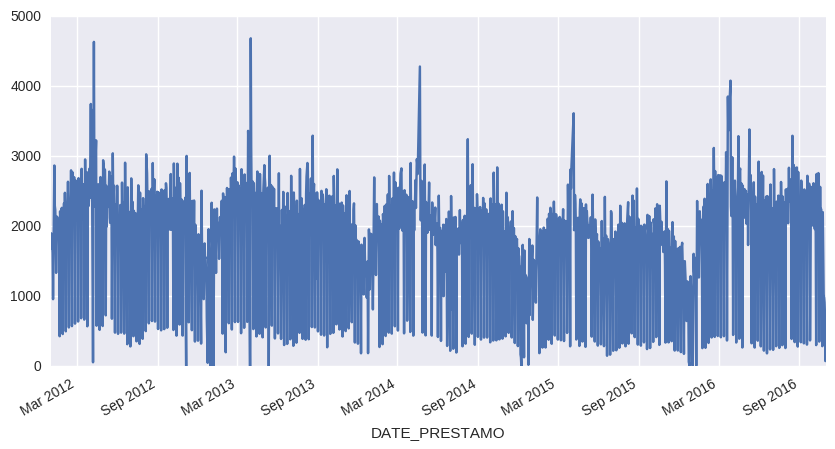

In [8]:
prestamos_fecha.plot(figsize=(10,5))

### Distribución del número de préstamos

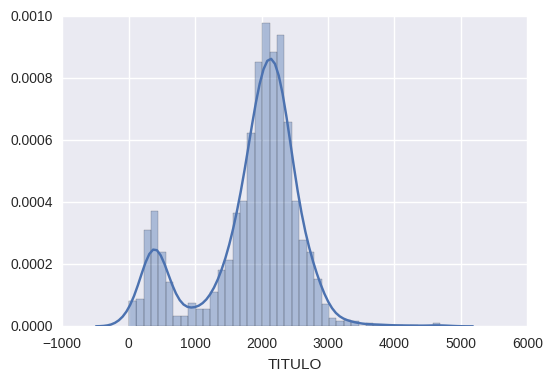

In [9]:
sns.distplot(prestamos_fecha)

### Valores medios por cada tres días

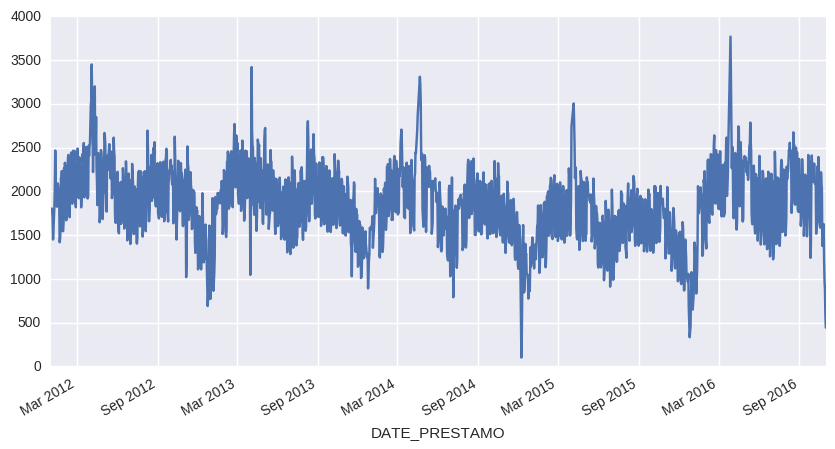

In [10]:
prestamos_fecha.rolling(window=3).mean().plot(figsize=(10,5))

### Valores máximos por cada tres días

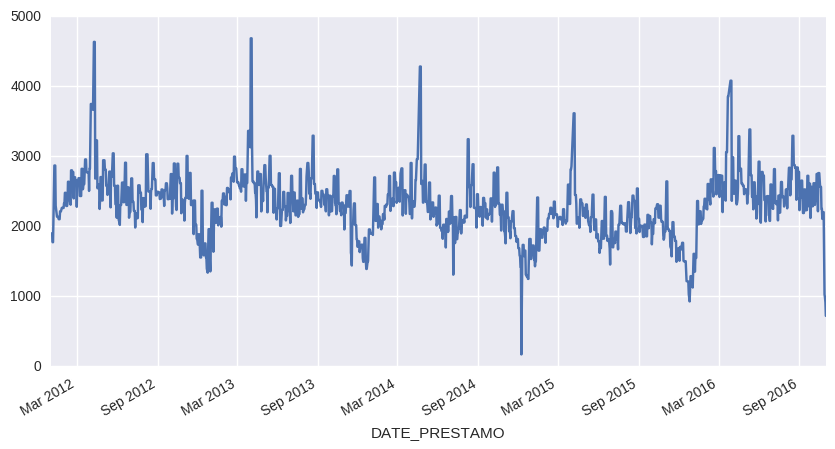

In [11]:
prestamos_fecha.rolling(window=3).max().plot(figsize=(10,5))

## Sucursales

In [12]:
sucursales = {
    'ARM': 'Armenia',
    'BLAA': 'Luis Angel Arango',
    'BUE': 'Buenaventura',
    'CAL': 'Cali',
    'CAR': 'Cartagena',
    'CASAGO': 'Casa Gómez Campuzano',
    'CATMAN': 'Catalogación y Mantenimiento de Colecciones',
    'CUC': 'Cúcuta',
    'FLO': 'Florencia',
    'GIR': 'Girardot',
    'HON': 'Honda',
    'IBA': 'Ibagué',
    'IEC': 'Investigaciones Económicas',
    'IPI': 'Ipiales',
    'LET': 'Leticia',
    'MAN': 'Manizales',
    'MED': 'Medellín',
    'MON': 'Montería',
    'NEI': 'Neiva',
    'PAS': 'Pasto',
    'PER': 'Pereira',
    'POP': 'Popayán',
    'QUI': 'Quibdó',
    'RIO': 'Riohacha',
    'SAN': 'San Andrés',
    'SIN': 'Sincelejo',
    'STM': 'Santa Marta',
    'TUN': 'Tunja',
    'VAL': 'Valledupar',
}

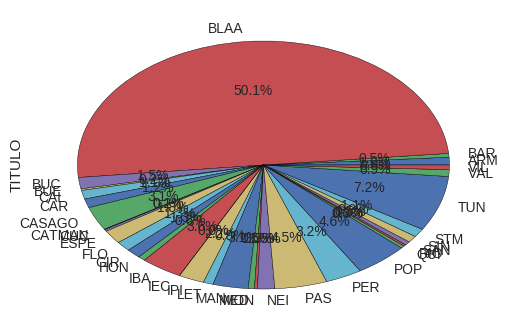

In [13]:
prestamos_df.groupby('SUCURSAL_PRESTAMO')['TITULO'].count().plot(kind='pie', autopct='%1.1f%%')

### Total préstamos por sucursal

In [14]:
prestamos_sucursal = prestamos_df.groupby('SUCURSAL_PRESTAMO')[['TITULO']].count()

In [15]:
prestamos_sucursal

,TITULO
SUCURSAL_PRESTAMO,
ARM,30545
BAR,15035
BLAA,1530725
BUC,45170
BUE,6510
CAL,34726
CAR,35157
CASAGO,94056
CATMAN,2088


### Total préstamos por sucursal y fecha

In [16]:
prestamos_sucursal_fecha = prestamos_df.groupby(['SUCURSAL_PRESTAMO', 'DATE_PRESTAMO'])['TITULO'].count()
prestamos_sucursal_fecha = prestamos_sucursal_fecha.unstack(level=0).fillna(0)

In [17]:
prestamos_sucursal_fecha.head()

SUCURSAL_PRESTAMO,ARM,BAR,BLAA,BUC,BUE,CAL,CAR,CASAGO,CATMAN,CUC,...,PER,POP,QUI,RIO,SAN,SIN,STM,TUN,VAL,VIL
DATE_PRESTAMO,,,,,,,,,,,,,,,,,,,,,
2012-01-02,0.0,9.0,1101.0,33.0,8.0,14.0,18.0,30.0,0.0,8.0,...,66.0,65.0,0.0,7.0,1.0,11.0,32.0,95.0,29.0,9.0
2012-01-03,22.0,6.0,1266.0,22.0,1.0,24.0,26.0,55.0,0.0,1.0,...,50.0,62.0,0.0,0.0,1.0,18.0,11.0,101.0,22.0,6.0
2012-01-04,1.0,1.0,1116.0,16.0,3.0,14.0,20.0,40.0,0.0,15.0,...,52.0,70.0,2.0,2.0,4.0,15.0,19.0,74.0,11.0,7.0
2012-01-05,2.0,7.0,1155.0,76.0,0.0,31.0,19.0,66.0,0.0,4.0,...,53.0,0.0,3.0,3.0,7.0,8.0,7.0,105.0,7.0,10.0
2012-01-06,15.0,12.0,1040.0,51.0,4.0,26.0,16.0,44.0,0.0,2.0,...,59.0,0.0,0.0,0.0,9.0,24.0,18.0,70.0,13.0,16.0


### Ejemplo comparación dos sucursales

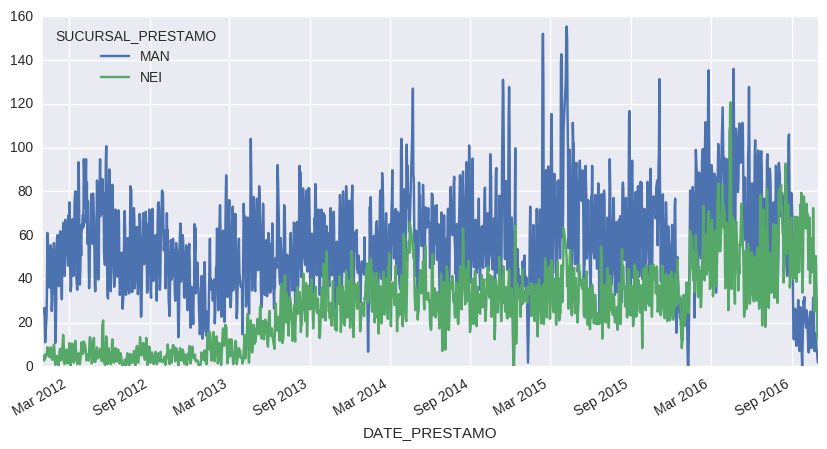

In [18]:
prestamos_sucursal_fecha[['MAN', 'NEI']].rolling(window=3).mean().plot(figsize=(10,5))

### Número de préstamos por sucursal y fecha

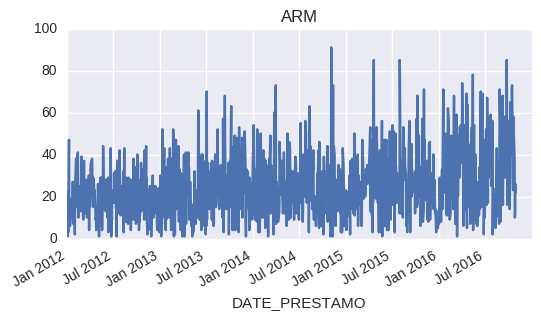

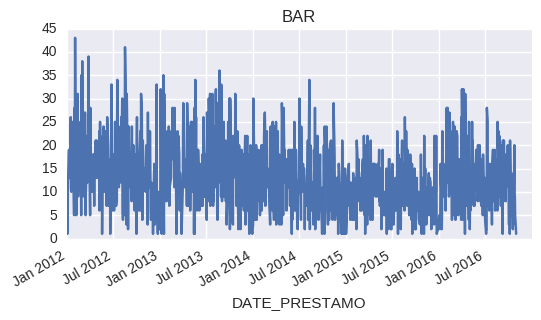

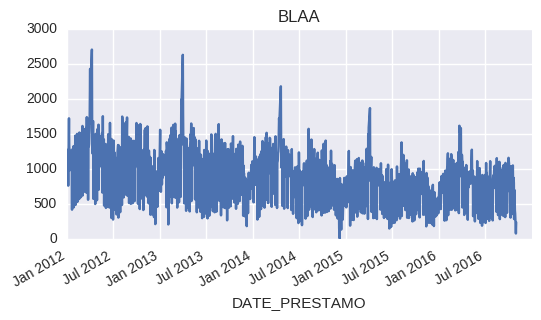

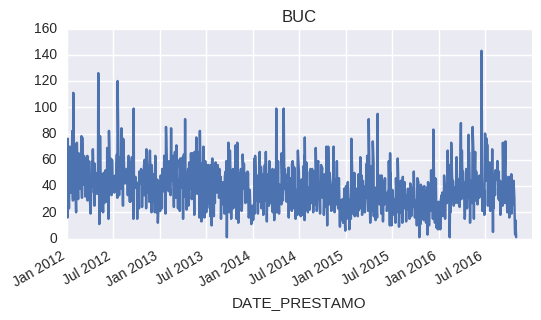

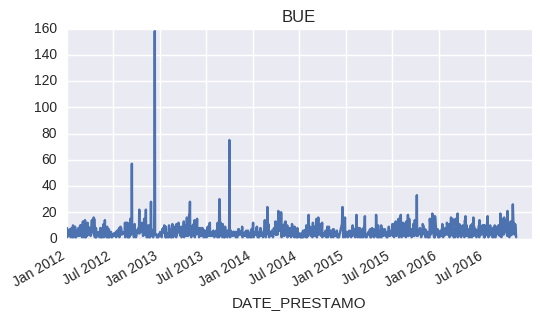

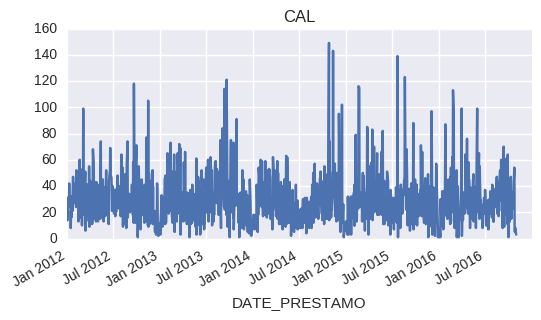

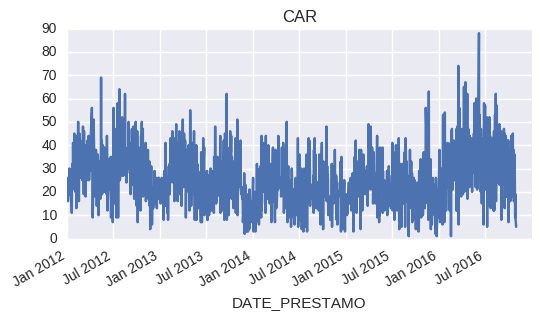

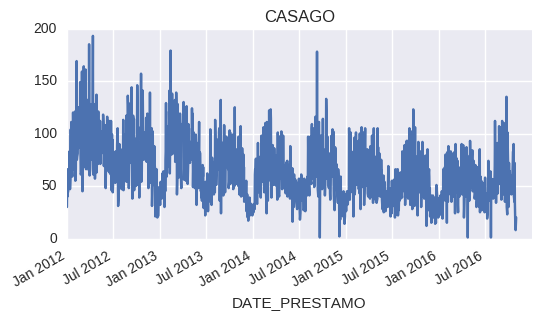

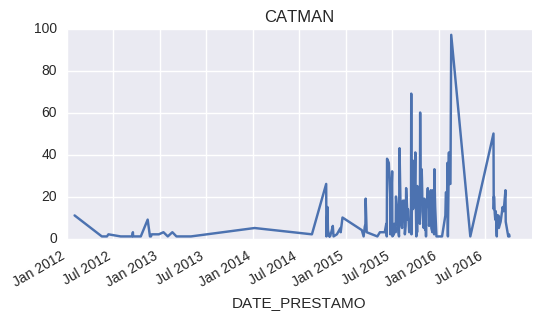

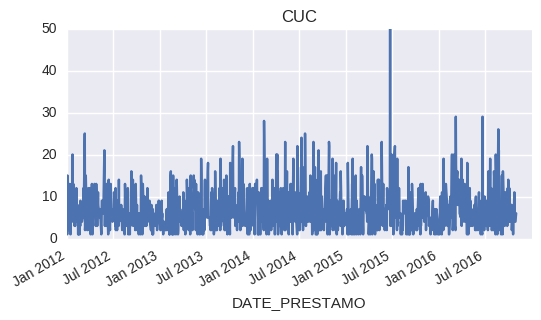

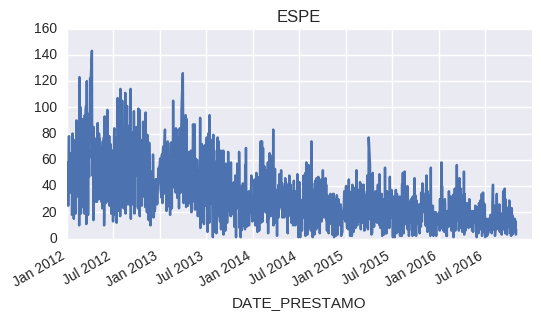

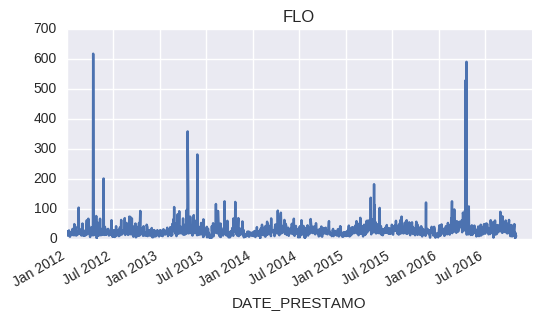

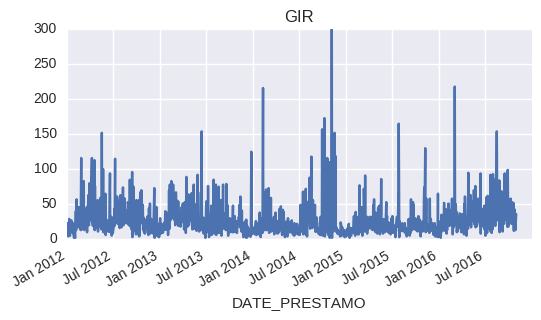

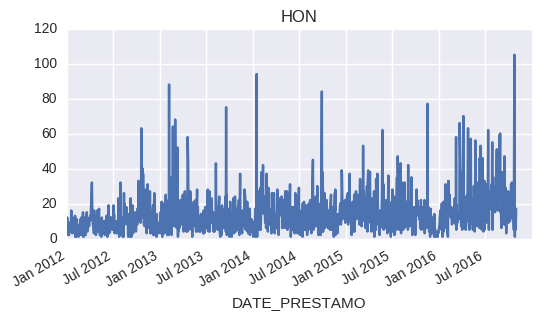

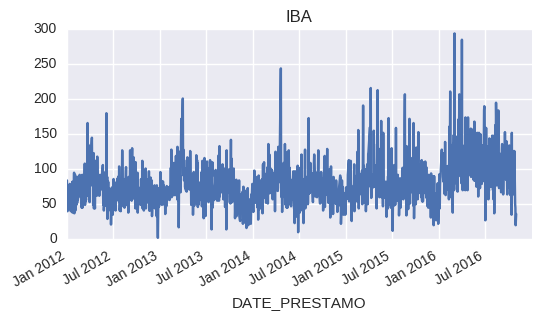

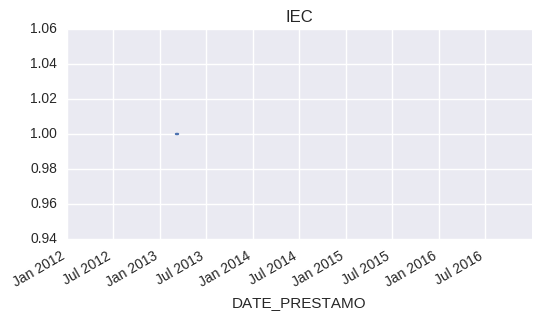

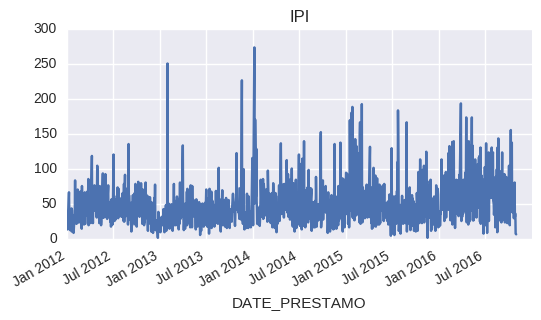

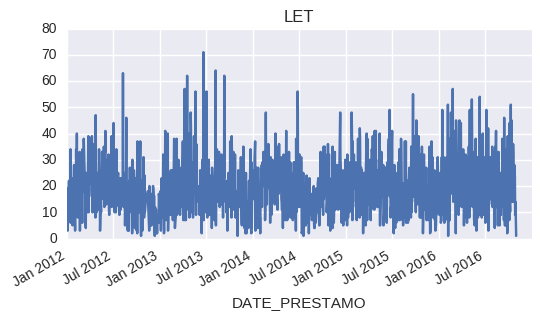

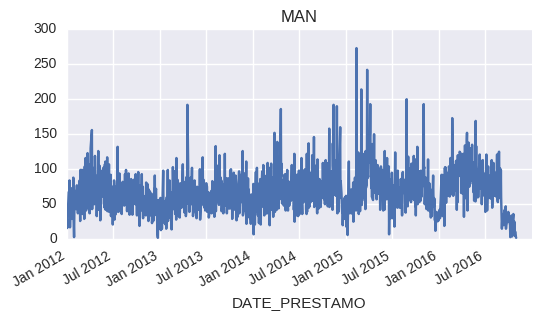

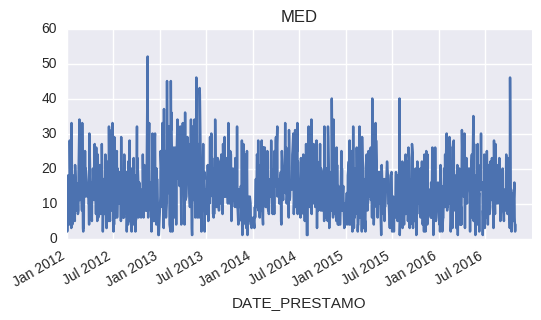

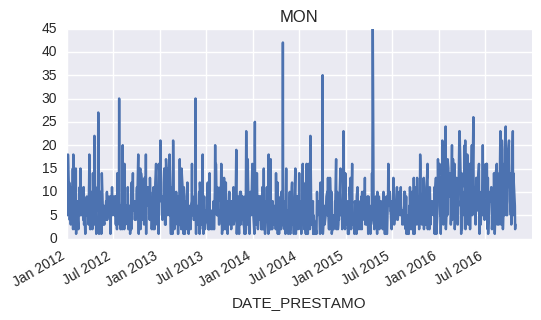

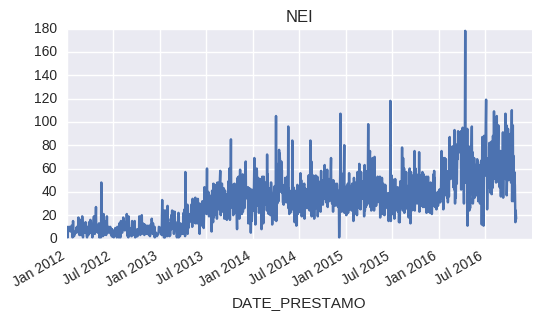

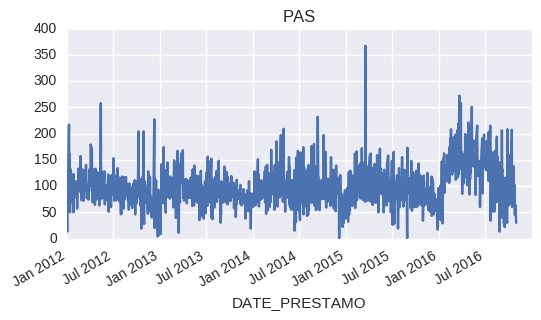

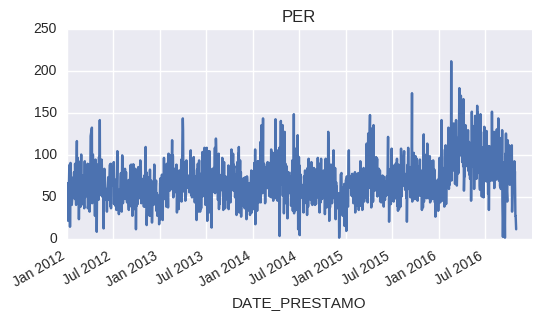

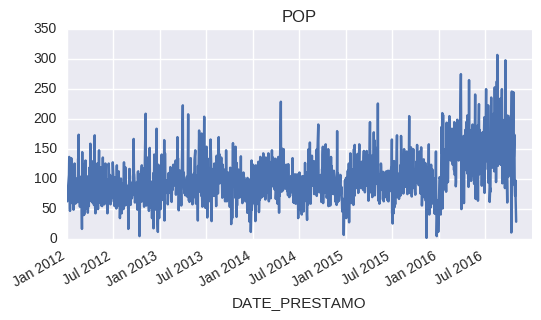

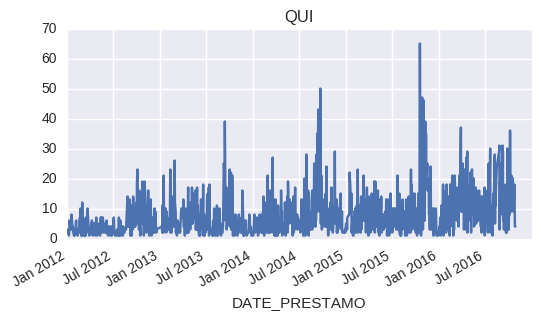

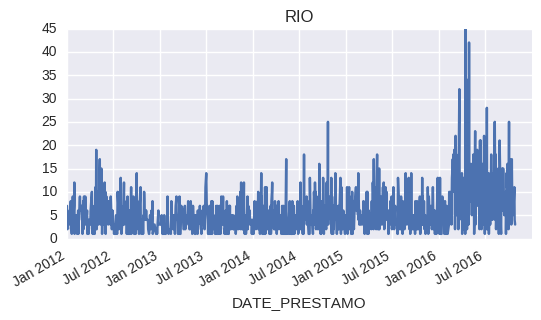

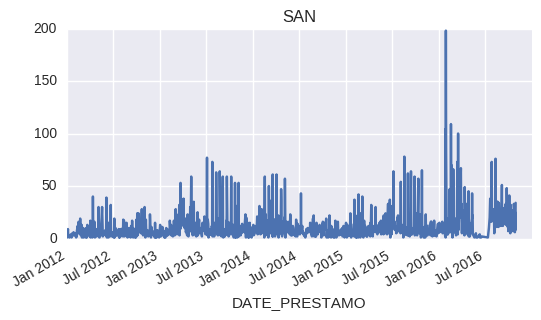

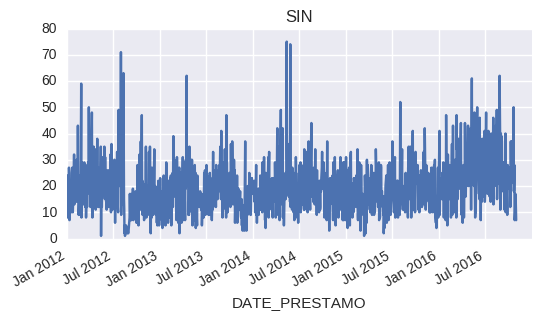

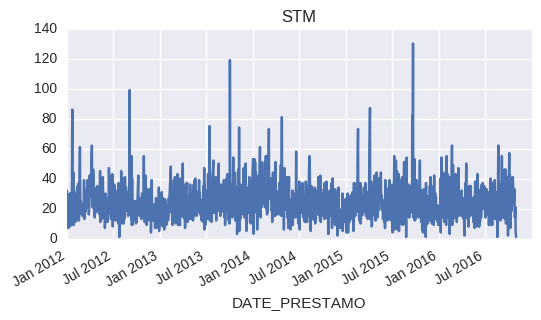

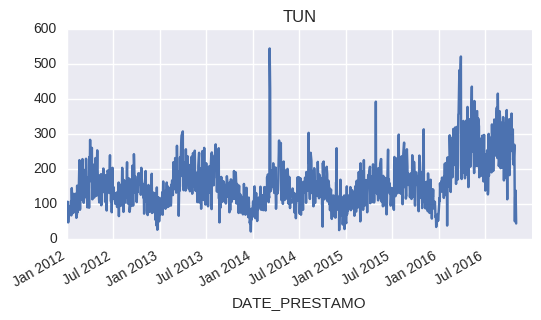

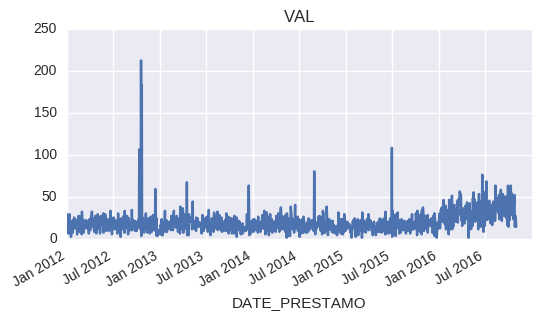

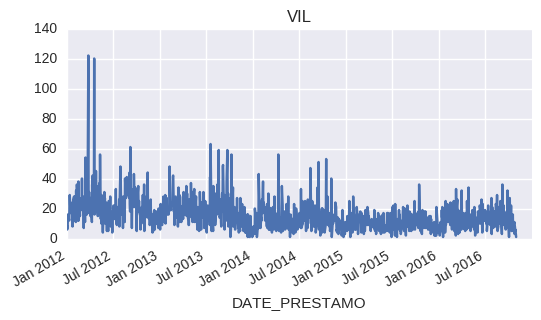

In [19]:
for sucursal, group in prestamos_df.groupby('SUCURSAL_PRESTAMO'):
    plt.figure()
    group.groupby('DATE_PRESTAMO')['TITULO'].count().plot(
        figsize=(6,3),
        xlim=('01-01-2012', '31-12-2016'),
        title=sucursal,
    )

## Topics

In [15]:
topics = {}
with open('dewey.txt') as f:
    for line in f:
        chunks = line.strip().split()
        dewey = chunks[0]
        topic = ' '.join(chunks[1:])
        topics[dewey] = topic

### Total préstamos por topic

In [4]:
all_prestamos_topic = prestamos_df.groupby('DEWEY')[['TITULO']].count()

#### Incorrect topic

In [5]:
all_prestamos_topic.ix[('000' > all_prestamos_topic.index) | (all_prestamos_topic.index > '999')].sum()

TITULO    131564
dtype: int64

#### Correct topic

In [6]:
all_prestamos_topic.ix[('000' <= all_prestamos_topic.index) & (all_prestamos_topic.index <= '999')].sum()

TITULO    2922796
dtype: int64

In [7]:
prestamos_topic_ok_df = prestamos_df[('000' <= prestamos_df['DEWEY']) & (prestamos_df['DEWEY'] <= '999')]

In [8]:
prestamos_topic = prestamos_topic_ok_df.groupby('DEWEY')[['TITULO']].count()

In [11]:
prestamos_topic.head()

,TITULO
DEWEY,
000,294
001,14396
002,1033
003,1774
004,3667


In [18]:
t = len(prestamos_topic_ok_df)
for x, y in prestamos_topic_ok_df.groupby('DEWEY')['TITULO']:
    if y.count() > 25000:
        print(str(x).split()[0], topics[str(x).split()[0]], '-', y.count(), 'préstamos', y.count()*100/t, '%')
        print()

301 Sociology & anthropology - 40544 préstamos 1.38716489279 %

303 Social processes - 30050 préstamos 1.02812512403 %

306 Culture & institutions - 25789 préstamos 0.882340060682 %

320 Political science (Politics & government) - 38855 préstamos 1.3293777602 %

330 Economics - 29811 préstamos 1.01994802237 %

347 Procedure & courts - 27350 préstamos 0.935747825028 %

370 Education - 39760 préstamos 1.36034126227 %

371 Schools & their activities; special education - 31119 préstamos 1.06469969167 %

372 Primary education (elementary education) - 42894 préstamos 1.46756735674 %

616 Diseases - 29128 préstamos 0.996579987108 %

658 General management - 54450 préstamos 1.86294219644 %

741 Drawing & drawings - 37060 préstamos 1.26796396327 %

808 Rhetoric & collections of literary texts from more than two literatures - 54355 préstamos 1.85969188407 %

813 American fiction in English - 112589 préstamos 3.85209915437 %

823 English fiction - 90231 préstamos 3.08714669105 %

833 German ficti

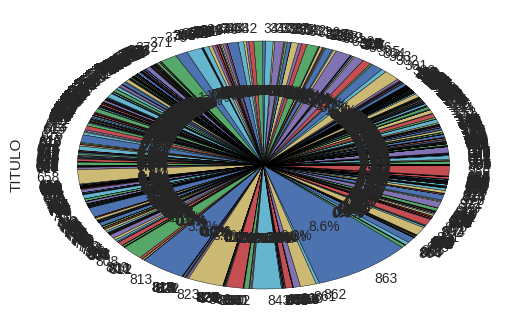

In [27]:
prestamos_topic_ok_df.groupby('DEWEY')['TITULO'].count().plot(kind='pie', autopct='%1.1f%%')

### Total préstamos por topic y fecha

In [28]:
prestamos_topic_fecha = prestamos_topic_ok_df.groupby(['DEWEY', 'DATE_PRESTAMO'])['TITULO'].count()
prestamos_topic_fecha = prestamos_topic_fecha.unstack(level=0).fillna(0)

In [29]:
prestamos_topic_fecha.head()

DEWEY,000,001,002,003,004,005,006,007,008,009,...,989,990,991,993,994,995,996,997,998,999
DATE_PRESTAMO,,,,,,,,,,,,,,,,,,,,,
2012-01-02,0.0,8.0,1.0,1.0,1.0,13.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-03,0.0,4.0,0.0,3.0,6.0,17.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-04,0.0,11.0,0.0,1.0,6.0,12.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-05,0.0,10.0,1.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-01-06,0.0,5.0,1.0,0.0,2.0,10.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Ejemplo comparación dos topics

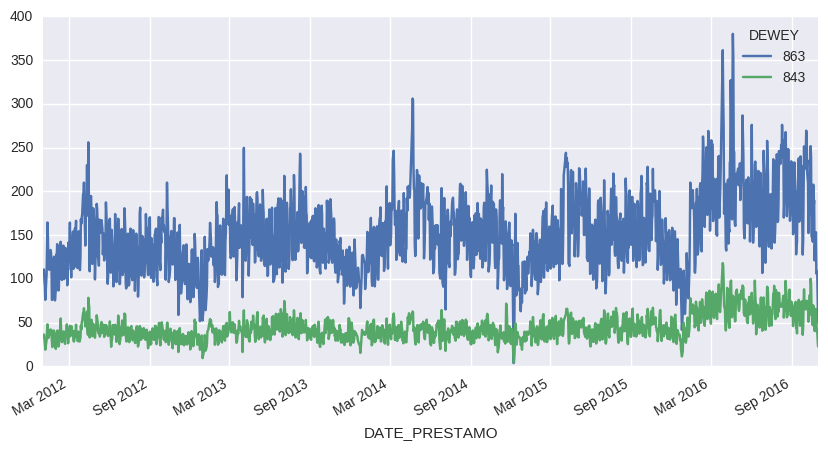

In [30]:
prestamos_topic_fecha[['863', '843']].rolling(window=3).mean().plot(figsize=(10,5))

### Top topics

In [31]:
indices = prestamos_topic[prestamos_topic['TITULO'] > 40000].index

In [32]:
indices

Index(['301', '372', '658', '808', '813', '823', '833', '843', '861', '863',
       '986'],
      dtype='object', name='DEWEY')

In [33]:
prestamos_top_topics_df = prestamos_df[prestamos_df['DEWEY'].map(lambda x: x in indices)]

In [34]:
prestamos_top_topics_df.head()

,TITULO,AUTOR,SUCURSAL,COD_BARRAS_LIBRO,DEWEY,DESC_LOCALIZACION_EJEMPLAR,FECHA_PUB,PAIS_EJEMPLAR,OCUPACION,NIVEL_EDUCACION,AREA_ESTUDIO,SUCURSAL_PRESTAMO,SUCURSAL_DEVOLUCION,SUCURSAL_DEL_LECTOR,COD_BARRAS_LECTOR,CATEGORÍA,FECHA_PRESTAMO,FECHA_REAL_DEVOLUCION,DATE_PRESTAMO,DATE_DEVOLUCION
0,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429527,CTA,22/01/2015,04/02/2015,2015-01-22,2015-02-04
1,Un bicho extraño,"Daporta, Mon.",ARM,2298061,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88416381,CTA,31/03/2015,07/04/2015,2015-03-31,2015-04-07
4,La fantástica leyenda de: la princesa y el dragón,"Alins, Sonia.",ARM,2288896,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429529,CTA,21/01/2015,28/01/2015,2015-01-21,2015-01-28
5,La fantástica leyenda de: la princesa y el dragón,"Alins, Sonia.",ARM,2288896,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88429422,CTA,11/02/2015,17/02/2015,2015-02-11,2015-02-17
6,La fantástica leyenda de: la princesa y el dragón,"Alins, Sonia.",ARM,2288896,863,Infantil,2010,sp,,,,ARM,ARM,ARM,88388144,CTA,05/11/2015,03/12/2015,2015-11-05,2015-12-03


### Número de préstamos por top topic y fecha

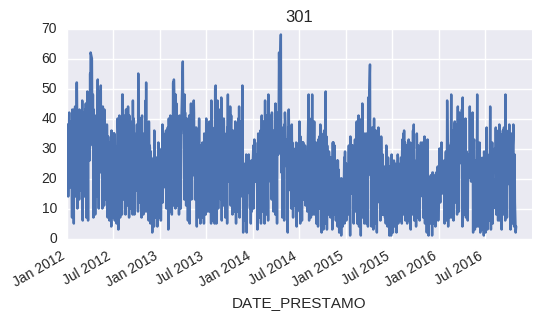

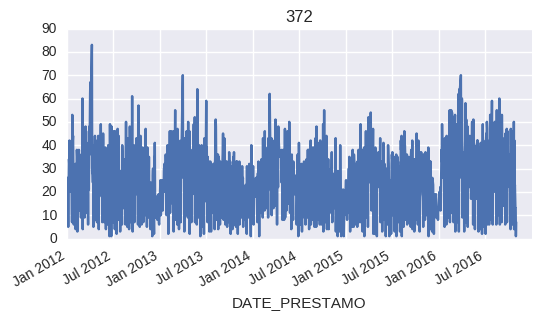

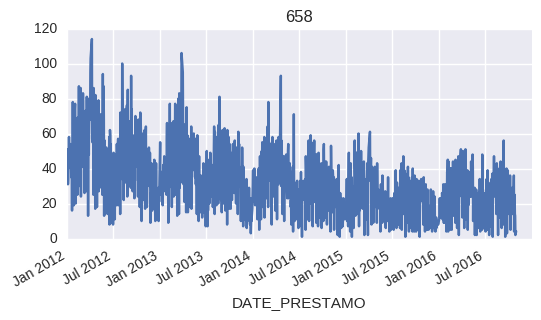

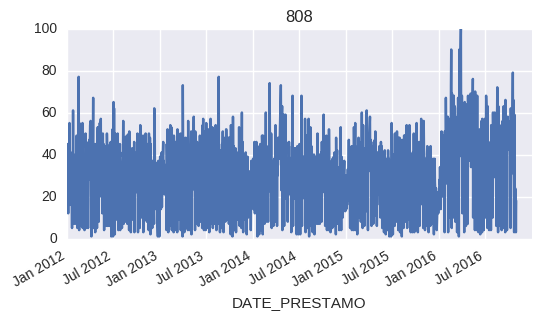

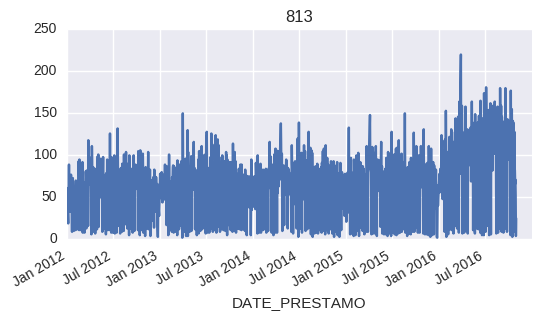

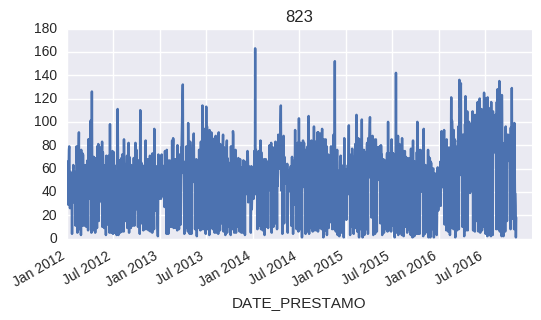

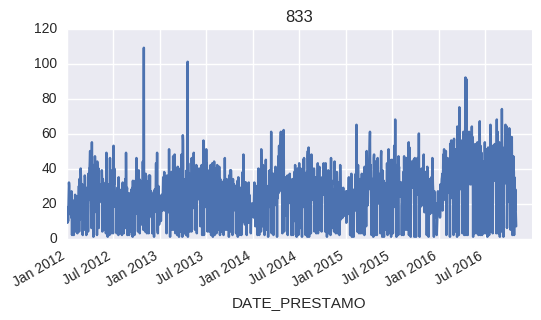

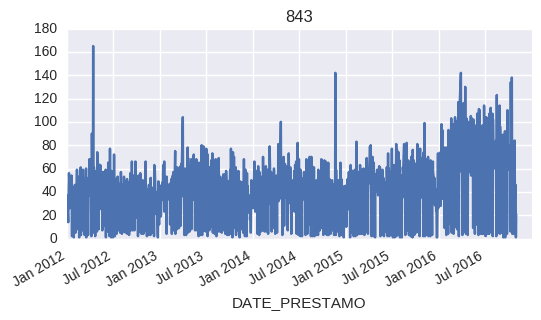

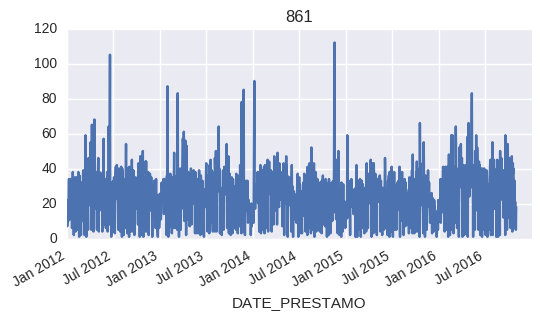

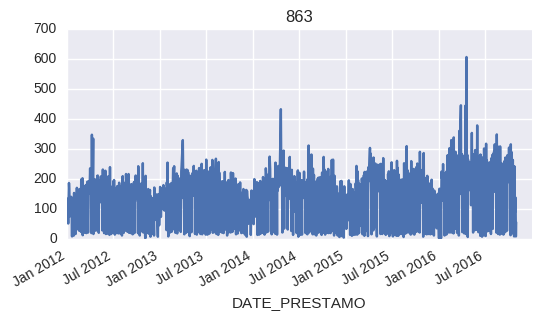

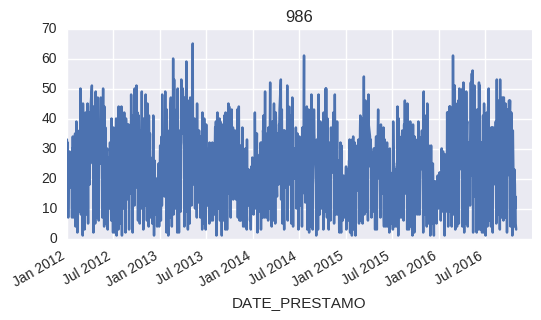

In [35]:
for topic, group in prestamos_top_topics_df.groupby('DEWEY'):
    plt.figure()
    group.groupby('DATE_PRESTAMO')['TITULO'].count().plot(
        figsize=(6,3),
        xlim=('01-01-2012', '31-12-2016'),
        title=topic,
    )

## Año publicación

### Número de préstamos por año de publicación

In [20]:
prestamos_pub = prestamos_df.groupby('FECHA_PUB')['TITULO'].count()

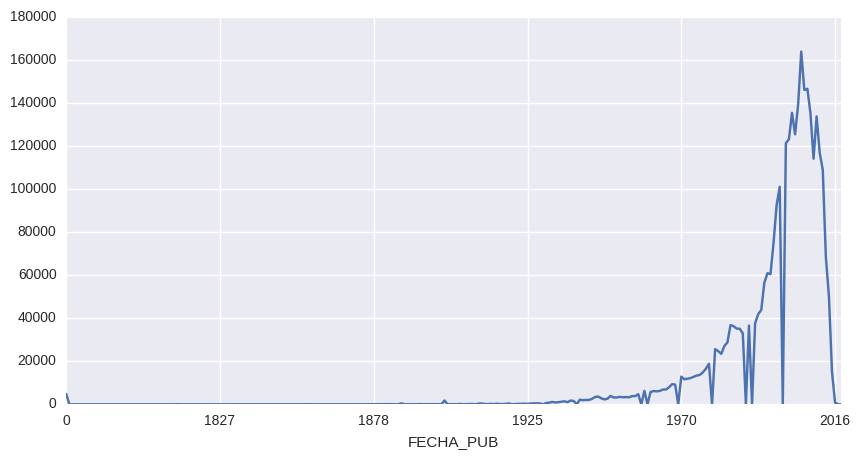

In [26]:
prestamos_pub.plot(figsize=(10,5))

## Usuarios

1.       CTA: categoría para niños y jóvenes hasta bachillerato
2.       CTI: categoría infantil, hasta doce años y solo es para Bogotá (blaa –biblioteca Luis Ángel Arango)
3.       CTB: público general (solo permite préstamo de libros)
4.       CTC: público en general (permite préstamo de libros y material audiovisual)
5.       CTF: categoría familiar, pueden acceder a los beneficios hasta tres personas del grupo familiar que se asocia
6.       CE1, CE2, CE2: categorías empresariales (solo para instituciones)
7.       CIS: categoría Inclusión Social
8.       CTU: categoría Universitaria
9.       VIP: Investigadores, préstamo de 30 materiales (libros y material audiovisual)

In [39]:
categorias_usuario = {
    'CTA': 'categoría para niños y jóvenes hasta bachillerato',
    'CTI': 'categoría infantil, hasta doce años y solo es para Bogotá (blaa –biblioteca Luis Ángel Arango)',
    'CTB': 'público general (solo permite préstamo de libros)',
    'CTC': 'público en general (permite préstamo de libros y material audiovisual)',
    'CTF': 'categoría familiar, pueden acceder a los beneficios hasta tres personas del grupo familiar que se asocia',
    'CE1': 'categorías empresariales (solo para instituciones) 1',
    'CE2': 'categorías empresariales (solo para instituciones) 2',
    'CE3': 'categorías empresariales (solo para instituciones) 3',
    'CIS': 'categoría Inclusión Social',
    'CTU': 'categoría Universitaria',
    'VIP': 'Investigadores, préstamo de 30 materiales (libros y material audiovisual)',
}

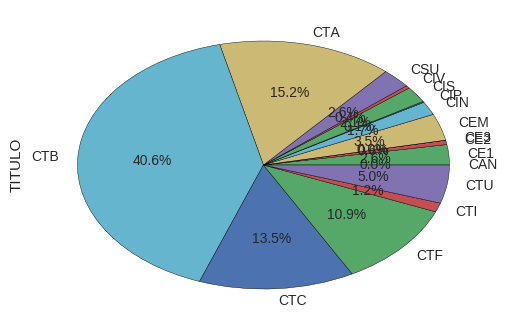

In [40]:
prestamos_df.groupby('CATEGORÍA')['TITULO'].count().plot(kind='pie', autopct='%1.1f%%')

In [41]:
prestamos_usuario = prestamos_df.groupby('CATEGORÍA')[['TITULO']].count()

In [42]:
prestamos_usuario

,TITULO
CATEGORÍA,
CAN,8
CE1,80702
CE2,17398
CE3,1
CEM,106300
CIN,53376
CIP,3958
CIS,64114
CIV,11069


### Número de préstamos por usuario y fecha

/home/antonio/.virtualenvs/colombia/lib/python3.4/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735555.0, right=735555.0
  'left=%s, right=%s') % (left, right))


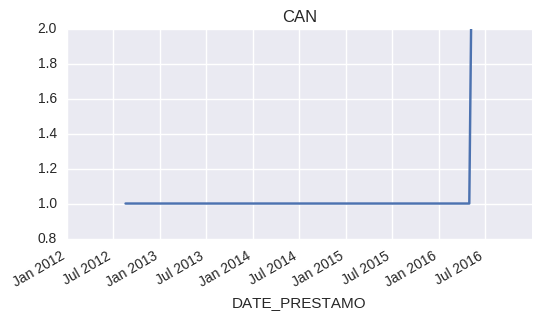

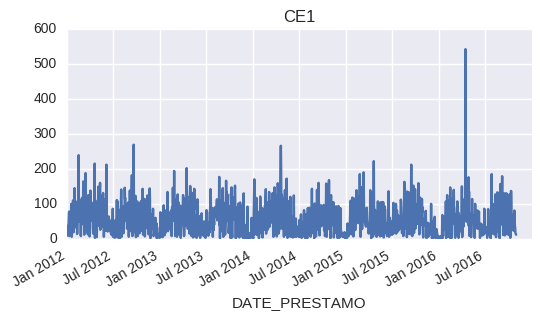

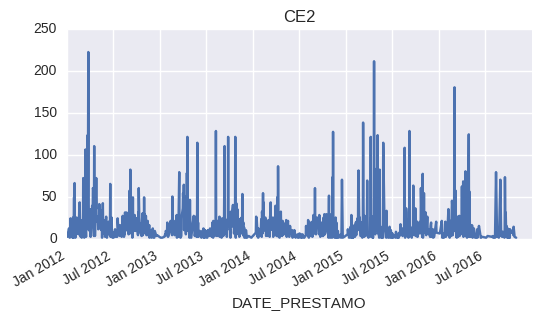

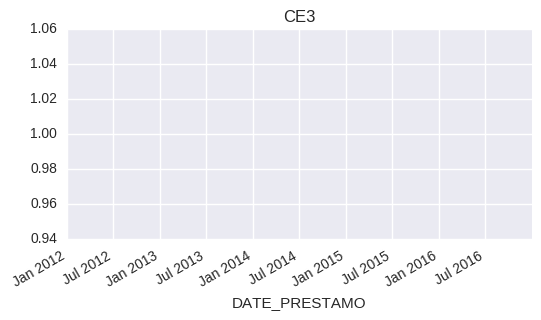

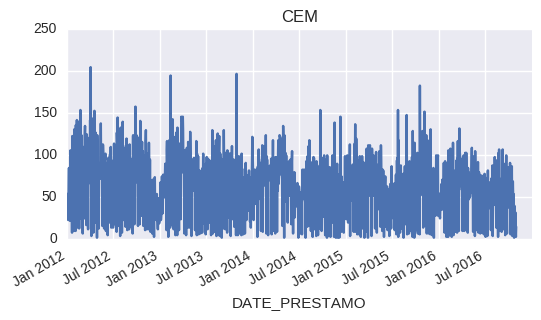

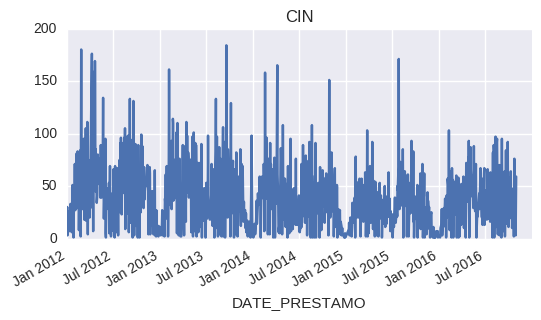

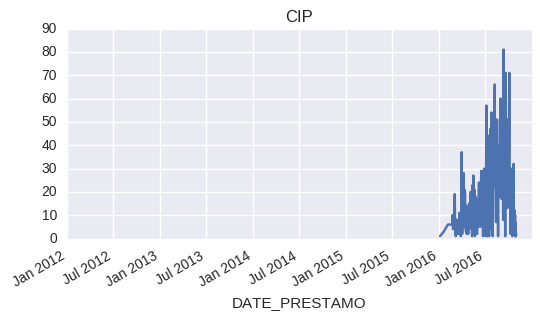

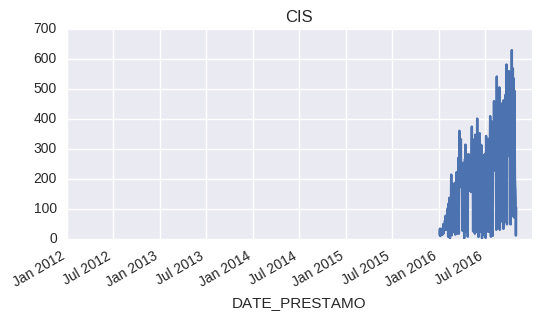

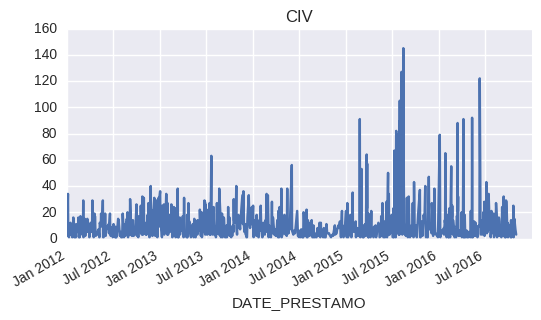

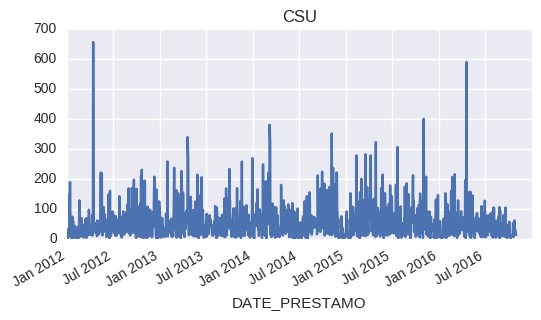

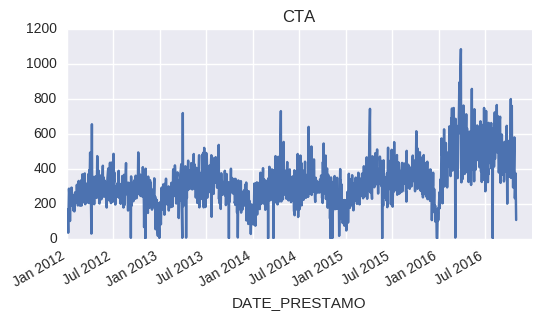

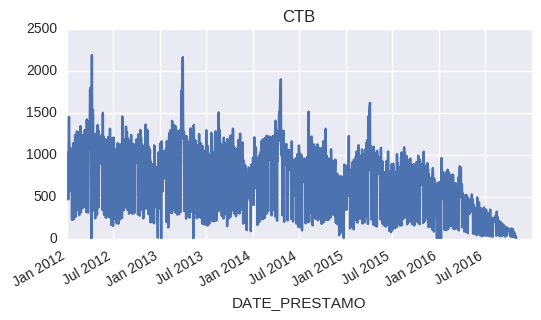

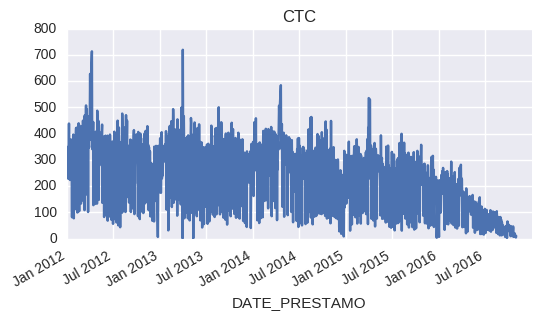

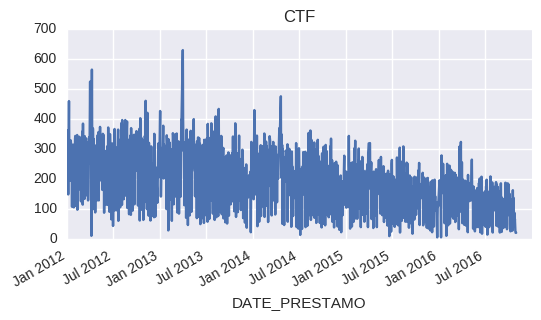

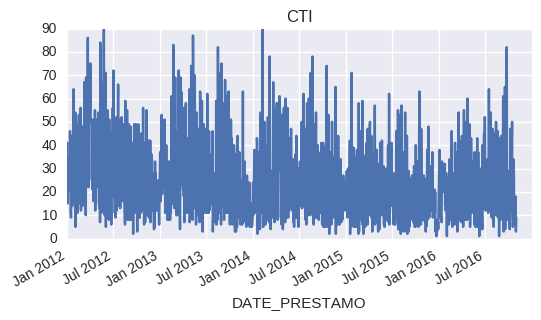

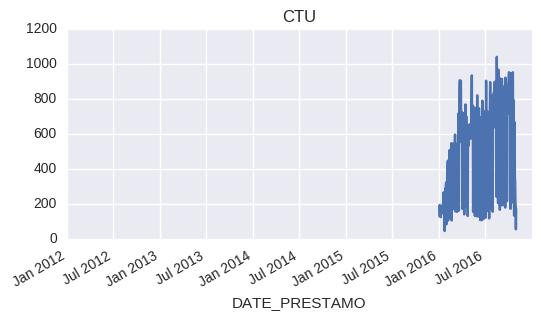

In [43]:
for usuario, group in prestamos_df.groupby('CATEGORÍA'):
    plt.figure()
    group.groupby('DATE_PRESTAMO')['TITULO'].count().plot(
        figsize=(6,3),
        xlim=('01-01-2012', '31-12-2016'),
        title=usuario,
    )

### Ejemplo comparación dos usuarios

In [44]:
prestamos_usuario_fecha = prestamos_df.groupby(['CATEGORÍA', 'DATE_PRESTAMO'])['TITULO'].count()
prestamos_usuario_fecha = prestamos_usuario_fecha.unstack(level=0).fillna(0)

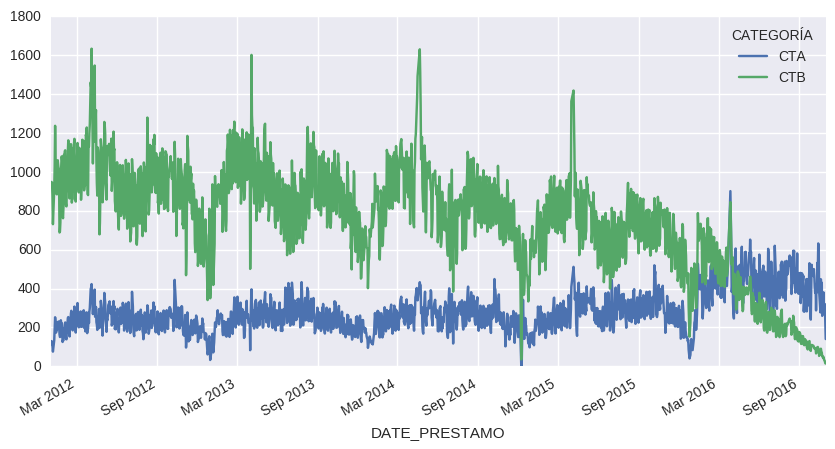

In [45]:
prestamos_usuario_fecha[['CTA', 'CTB']].rolling(window=3).mean().plot(figsize=(10,5))

### Top días por año

In [46]:
for x, y in prestamos_df.groupby('DATE_PRESTAMO')['TITULO']:
    if y.count() > 5000:
        print(str(x).split()[0],'-', y.count(), 'préstamos')
        print()

In [47]:
top_dias = prestamos_df[prestamos_df['DATE_PRESTAMO'].map(lambda x: x in [
            pd.tslib.Timestamp('2012-04-09'),
            pd.tslib.Timestamp('2013-04-01'),
            pd.tslib.Timestamp('2014-04-21'),
            pd.tslib.Timestamp('2015-04-06'),
            pd.tslib.Timestamp('2016-03-28')])]

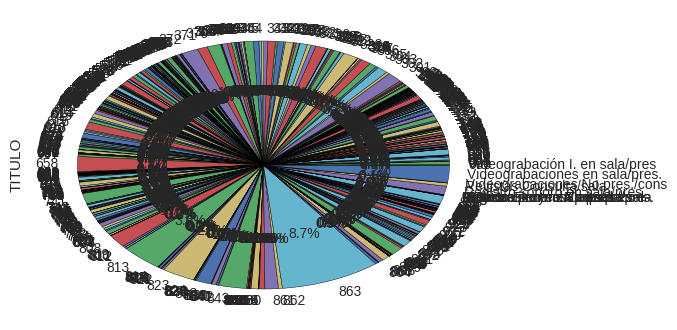

In [48]:
top_dias.groupby('DEWEY')['TITULO'].count().plot(kind='pie', autopct='%1.1f%%')

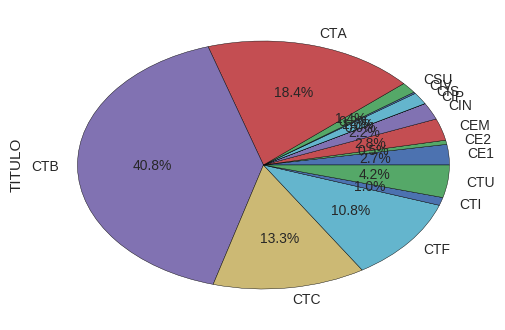

In [49]:
top_dias.groupby('CATEGORÍA')['TITULO'].count().plot(kind='pie', autopct='%1.1f%%')

## Título

In [29]:
qq=prestamos_df.groupby('TITULO')['AUTOR']

In [40]:
qq=prestamos_df.groupby(['TITULO', 'AUTOR']).count()

In [41]:
qq.ix['Obras completas'].

,SUCURSAL,COD_BARRAS_LIBRO,DEWEY,DESC_LOCALIZACION_EJEMPLAR,FECHA_PUB,PAIS_EJEMPLAR,OCUPACION,NIVEL_EDUCACION,AREA_ESTUDIO,SUCURSAL_PRESTAMO,SUCURSAL_DEVOLUCION,SUCURSAL_DEL_LECTOR,COD_BARRAS_LECTOR,CATEGORÍA,FECHA_PRESTAMO,FECHA_REAL_DEVOLUCION,DATE_PRESTAMO,DATE_DEVOLUCION
AUTOR,,,,,,,,,,,,,,,,,,
"Acosta, Cecilio, 1818-1881.",2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
"Alas, Leopoldo, 1852-1901.",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"Alberti, Rafael, 1902-1999.",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"Aleixandre Ferrandis, Vicente, 1898-1984.",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"Alonso, Dámaso, 1898-1990.",2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
"Alvarez Quintero, Serafín, 1871-1938.",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Amigó y Ferrer, Luis, 1854-1934.",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
"Andreiev, Leonidas, 1871-1919.",3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
"Anselmo, Santo, Arzobispo de Canterbury, 1033-1109.",21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21,21


In [33]:
for a, b in qq:
    if b.count() > 900:
        print(a, b.count())

Algebra lineal 1549
Alicia en el país de las maravillas 1179
Antología poética 1485
Biología 1777
Cien años de soledad 1997
Crimen y castigo 1131
Cuentos 1539
Cuentos completos 1950
Cálculo 1457
Cálculo diferencial e integral 920
Derecho constitucional colombiano 999
Diálogos 1219
Don Quijote de la Mancha 1081
El amor en los tiempos del cólera 1451
El mundo de Sofía : novela sobre la historia de la filosofía 987
El principito 1330
El retrato de Dorian Gray 1283
El túnel 1213
En el trayecto ... aprende escuchando dónde quieras y cuándo 1294
Ensayo sobre la ceguera 1032
Física 2013
Física universitaria 1368
Historia de la filosofía 1154
Historia de la sexualidad 902
Jugando con la plastilina 1181
Las mil y una noches 954
Metodología de la investigación 1605
Obras 919
Obras completas 4060
Opio en las nubes 1272
Química 1745
Química orgánica 1361
Rayuela 1501


In [32]:
for a, b in qq:
    if b.count() > 1000:
        print(a, b.count())

Algebra lineal 1549
Alicia en el país de las maravillas 1179
Antología poética 1485
Biología 1777
Cien años de soledad 1997
Crimen y castigo 1131
Cuentos 1539
Cuentos completos 1950
Cálculo 1457
Diálogos 1219
Don Quijote de la Mancha 1081
El amor en los tiempos del cólera 1451
El principito 1330
El retrato de Dorian Gray 1283
El túnel 1213
En el trayecto ... aprende escuchando dónde quieras y cuándo 1294
Ensayo sobre la ceguera 1032
Física 2013
Física universitaria 1368
Historia de la filosofía 1154
Jugando con la plastilina 1181
Metodología de la investigación 1605
Obras completas 4060
Opio en las nubes 1272
Química 1745
Química orgánica 1361
Rayuela 1501


In [51]:
prestamos_df.groupby(prestamos_df.DATE_PRESTAMO)['TITULO'].count()['2012-04-07']

58

In [52]:
for x, y in prestamos_df.groupby(prestamos_df.DATE_DEVOLUCION)['TITULO']:
    if y.count() > 3500:
        print(x)
        print(y.count())
        print()

2012-03-20 00:00:00
4309

2012-04-09 00:00:00
7097

2012-05-02 00:00:00
3654

2012-05-22 00:00:00
4224

2012-06-12 00:00:00
3668

2012-06-19 00:00:00
3550

2012-08-08 00:00:00
3518

2012-08-21 00:00:00
3663

2012-10-16 00:00:00
3811

2012-11-06 00:00:00
4055

2012-11-13 00:00:00
3740

2013-04-01 00:00:00
8010

2013-04-02 00:00:00
4093

2013-05-02 00:00:00
3886

2013-05-14 00:00:00
3886

2013-06-04 00:00:00
3878

2013-07-02 00:00:00
3591

2013-07-22 00:00:00
3577

2013-08-20 00:00:00
4061

2013-10-15 00:00:00
3794

2013-11-05 00:00:00
3651

2014-03-31 00:00:00
3890

2014-04-21 00:00:00
6613

2014-06-03 00:00:00
3578

2014-10-14 00:00:00
3690

2015-04-06 00:00:00
5490

2015-11-03 00:00:00
3544

2016-03-28 00:00:00
5882

2016-05-10 00:00:00
4639

2016-05-31 00:00:00
4027

2016-06-07 00:00:00
3871

2016-07-05 00:00:00
3788

2016-08-16 00:00:00
3899

2016-10-18 00:00:00
3797



In [53]:
df = prestamos_df.groupby([prestamos_df.SUCURSAL_PRESTAMO, prestamos_df.DATE_PRESTAMO])['TITULO'].count()

## Fechas

In [54]:
dates = pd.date_range('2012-1-1', '2016-12-31', freq='MS')

In [55]:
dates

DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
      

In [56]:
# ranges = [(x, y - timedelta(1)) for x, y in zip(dates, dates[1:])]

In [57]:
# ranges

## Topics

In [58]:
# topics

## Sucursales

In [59]:
# %%time

# sucursales = {}
# for filename in os.listdir('prestamos_csv'):
#     if filename.endswith('.csv'):
#         with open('prestamos_csv/' + filename) as f:
#             reader = csv.reader(
#                 f,
#                 delimiter=',',
#                 quotechar='"'
#             )
#             next(reader)
#             for row in reader:
#                 sucursales[row[3]] = row[4]